# Path planning

## Point to point path planning

The goal is to implement the following equations to determine the values of the coefficients that form a cubic polynomial that represents the position of a robot joint at time $t$.

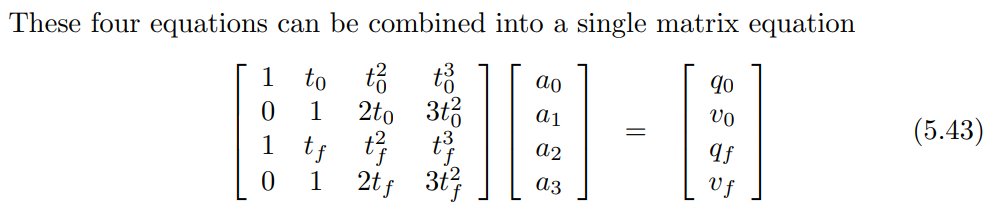

The polynomial is:
$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3$

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#get the variables
q0 = float(input('Enter the initial position q0: '))
qf = float(input('Enter the final position qf: '))
v0 = float(input('Enter the initial velocity v0: '))
vf = float(input('Enter the final velocity vf: '))
t0 = float(input('Enter the initial time t0: '))
tf = float(input('Enter the final time tf: '))

t = np.linspace(t0, tf, int(100 * (tf - t0))) #generate 100 points per second of time.
M = np.array(
[
    [1, t0, t0**2, t0**3],
    [0, 1, 2*t0, 3*t0**2],
    [1, tf, tf**2, tf**3],
    [0, 1, 2*tf, 3*tf**2]
], 
dtype = np.float64)

b = np.array([[q0], [v0], [qf], [vf]], dtype = np.float64)

a = np.linalg.inv(M) @ b

In [7]:
a

array([[ 10.],
       [  0.],
       [-90.],
       [ 60.]])

In [14]:
position = a[0, 0] + a[1, 0]*t + a[2, 0]*t**2 + a[3, 0]*t**3
velocity = a[1, 0] + 2*a[2, 0]*t + 3*a[3, 0]*t**2
acceleration = 2*a[2, 0] + 6*a[3, 0]*t

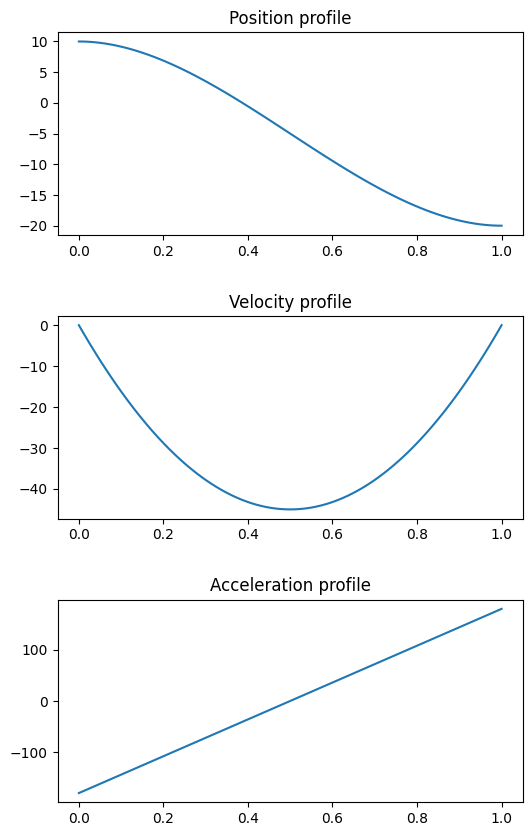

In [20]:

plt.figure(figsize = (6, 10))
plt.subplots_adjust(hspace = 0.4)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(t, position)

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(t, velocity)

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
plt.plot(t, acceleration)
plt.show()

The problem with cubic polynomials is that the acceleration profile has discontinuities in it, which causes the robot to create an impulsive jerk, which may make tracking the joint harder.

For this reason, we can set additional constraints on the initial and final acceleration, which means that we need to construct a 5th degree (6 coefficients) polynomial called a "Quintic polynomial".

The polynomial is: <br>
$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3 + a_4t^4 + a_5t^5$

By differentiating the polynomial twice to obtain a general equation for the acceleration and substituting values for the initial and final time, we obtain the following matrix:

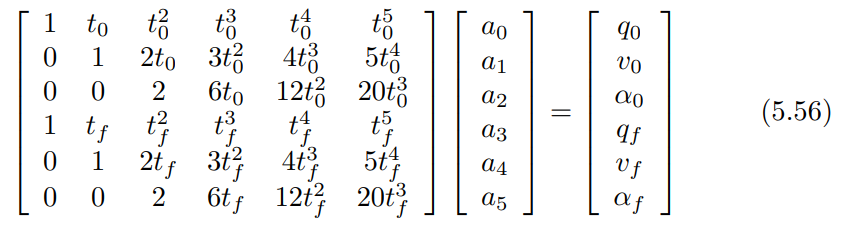

In [27]:
#implementing the quintic polynomial
#setting up the variables for the example
q0 = 0.
qf = 40.
v0 = 0.
vf = 0.
a0 = 0.
af = 0.
t0 = 0.
tf = 2.

#setting up the time axis
t = np.linspace(t0, tf, int(100 * (tf - t0)))
                
#implementing the matrix
M = np.array(
[
    [1, t0, t0**2, t0**3, t0**4, t0**5],
    [0, 1, 2*t0, 3*t0**2, 4*t0**3, 5*t0**4],
    [0, 0, 2, 6*t0, 12*t0**2, 20*t0**3],
    [1, tf, tf**2, tf**3, tf**4, tf**5],
    [0, 1, 2*tf, 3*tf**2, 4*tf**3, 5*tf**4],
    [0, 0, 2, 6*tf, 12*tf**2, 20*tf**3]
]
, dtype = np.float64)

#setting up the constraints vector
b = np.array(
[
    [q0],
    [v0],
    [a0],
    [qf],
    [vf],
    [af]
]
, dtype = np.float64)

#determining the values of the coefficients
a = np.linalg.inv(M) @ b

In [28]:
position = a[0, 0] + a[1, 0]*t + a[2, 0]*t**2 + a[3, 0]*t**3 + a[4, 0]*t**4 + a[5, 0]*t**5
velocity = a[1, 0] + 2*a[2, 0]*t + 3*a[3, 0]*t**2 + 4*a[4, 0]*t**3 + 5*a[5, 0]*t**4
acceleration = 2*a[2, 0] + 6*a[3, 0]*t + 12*a[4, 0]*t**2 + 20*a[5, 0]*t**3

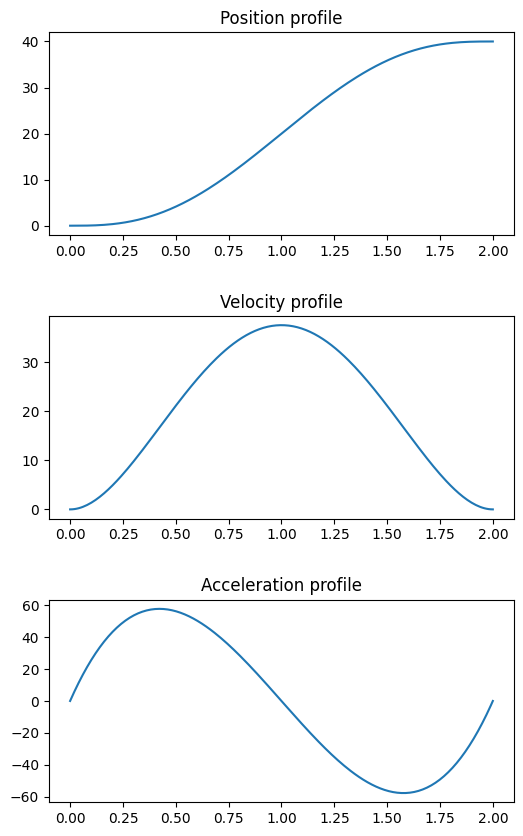

In [29]:
plt.figure(figsize = (6, 10))
plt.subplots_adjust(hspace = 0.4)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(t, position)

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(t, velocity)

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
plt.plot(t, acceleration)
plt.show()

As illustrated in the figure above, the acceleration profile is much better!

## Linear Segments with Parabolic Blends LSPB

The idea behind this method is to trace a path for the joint where the velocity ramps up to a maximum value and stays constant at that value until it starts ramping down again to zero.

The following are the position, velocity, and acceleration profiles of this method:

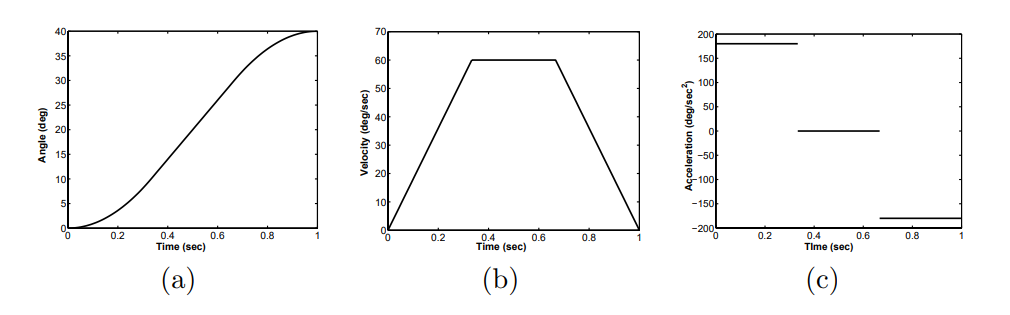

This equation is used to find the blend time:  $t_b = \frac{q_0 - q_f + Vt_f}{V} $ <br>
Note that the blend time should be: $0 < t_b \le t_f/2$

The following are the equations for each segment in the path. Note that you should differentiate with respect to time to get the velocity and acceleration equations.

$q(t) = 
\begin{cases} 
q_0 + \frac{a}{2}t^2 & 0 \le t \le t_b \\
\frac{q_f + q_0 - Vt_f}{2} + Vt & t_b < t \le t_f - t_b \\
q_f - \frac{at_f^2}{2} + at_ft - \frac{a}{2} t^2 & t_f-t_b < t \le t_f \end{cases}$

In [37]:
#Define assumed constraints for the above equations to apply
#These constraints are necessary since they were assumed to be set to these values
#when deriving the equations above.
t0 = 0
v0 = 0
vf = 0

#Get the variable constraints
#Note the the variables should satisfy the condition that the
#blending time is: 0 < tb <tf/2

tf = float(input('Enter the final time tf: '))
q0 = float(input('Enter the initial position q0: '))
qf = float(input('Enter the final position qf: '))
V = float(input('Enter the final velocity V: '))

tb = (q0 - qf + V*tf)/V #get the blending time
if tb > tf/2:
    raise ValueError('The values of initial conditions do not satisfy the condition that 0 < tb <= tf!')

a = V/tb #Calculate the constant a, which represents the acceleration.
t = np.linspace(t0, tf, int((tf - t0) * 100)) #get the time axis

position = np.zeros(shape = t.shape)
velocity = np.zeros(shape = t.shape)
acceleration = np.zeros(shape = t.shape)

mask = np.logical_and(t >= 0, t<= tb) #mask for the first segment
position[mask] = q0 + a/2 * t[mask]**2 #first segment
velocity[mask] = a*t[mask]
acceleration[mask] = a


mask = np.logical_and(t > tb, t <= tf-tb) #mask for the second segment
position[mask] = (qf + q0 - V*tf)/2 + V*t[mask] #second segment
velocity[mask] = V
acceleration[mask] = 0

mask = np.logical_and(t > tf-tb, t<= tf) #mask for the third segment
position[mask] = qf - (a*tf**2)/2 + a*tf*t[mask] - a/2 * t[mask]**2 #third segment
velocity[mask] = a*tf - a*t[mask]
acceleration[mask] = -a


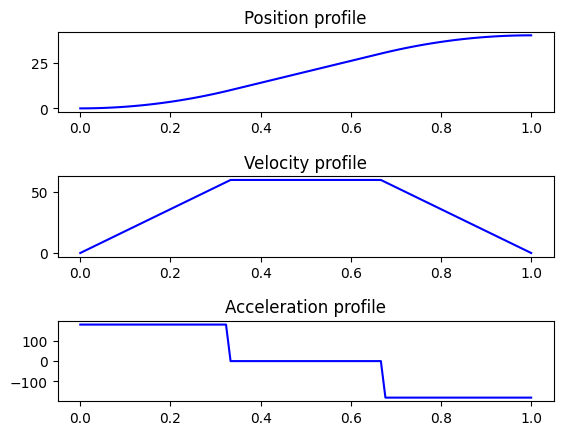

In [38]:
plt.subplots_adjust(hspace = 0.8)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(t, position, 'b-')

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(t, velocity, 'b-')

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
plt.plot(t, acceleration, 'b-')

plt.show()



## Path planning using Via points

If you are given a set of intermediate points, you can solve in one of two ways:
1. Construct a large polynomial that includes as many coefficients as there are constraints in the problem.
2. Treat each two points together as initial and final points, and solve them using a cubic polynomial.

Solving using the first method:

The equation of the polynomial is going to depend on the initial conditions of the system. You are only given the position of the via points, and you are required to construct the position, velocity, and acceleration profiles of the joint.

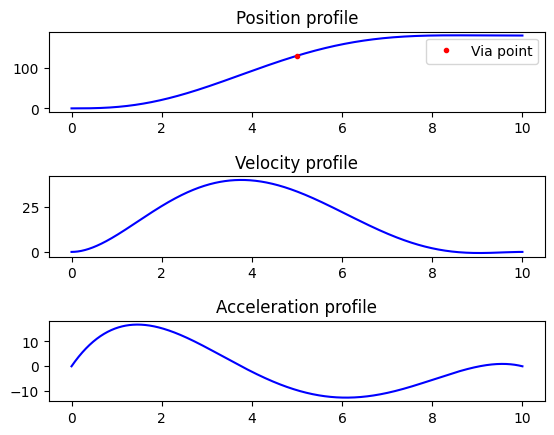

In [88]:
#Define the points
#The first and final points includes values for the position, velocity, and acceleration.
t0 = 0
q0 = 0
v0 = 0
a0 = 0

t1 = 5
q1 = 130


tf = 10
qf = 180
vf = 0
af = 0

t = np.linspace(t0, tf, int((tf - t0)*100))
M = np.array([
    [1, t0, t0**2, t0**3, t0**4, t0**5, t0**6],
    [0, 1, 2*t0, 3*t0**2, 4*t0**3, 5*t0**4, 6*t0**5],
    [0, 0, 2, 6*t0, 12*t0**2, 20*t0**3, 30*t0**4],
    [1, t1, t1**2, t1**3, t1**4, t1**5, t1**6],
    [1, tf, tf**2, tf**3, tf**4, tf**5, tf**6],
    [0, 1, 2*tf, 3*tf**2, 4*tf**3, 5*tf**4, 6*tf**5],
    [0, 0, 2, 6*tf, 12*tf**2, 20*tf**3, 30*tf**4],
])

b = np.array([
    [q0],
    [v0],
    [a0],
    [q1],
    [qf],
    [vf],
    [af]
])
a = np.linalg.inv(M) @ b
a = a[:, 0]

position = a[0] + a[1] * t + a[2] * t**2 + a[3] * t**3 + a[4] * t**4 + a[5] * t**5 + a[6] * t**6
velocity = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4] * t**3 + 5*a[5]*t**4 + 6*a[6]*t**5
acceleration = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3 + 30*a[6]*t**4

plt.subplots_adjust(hspace = 0.8)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(t, position, 'b-')
plt.plot(t1, q1, 'r.', label = 'Via point')
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(t, velocity, 'b-')

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
plt.plot(t, acceleration, 'b-')

plt.show()


Solving using the second method:

The polynomial equation is: <br>
$q(t) = a_0 + a_1 * (t-t_i) + a_2 * (t-t_i)^2 + a_3 * (t-t_i)^3$

In [85]:
#define the points
#t = time
#q = position
#v = velocity
n_points = 7


t0 = -2
q0 = 10
v0 = 0

t1 = 0
q1 = 10
v1 = 0

t2 = 2
q2 = 20
v2 = -10

t3 = 4
q3 = 0
v3 = 20

t4 = 8
q4 = 30
v4 = 3

t5 = 10
q5 = 40
v5 = 0

t6 = 12
q6 = 40
v6 = 0

t = [t0, t1, t2, t3, t4, t5, t6]
q = [q0, q1, q2, q3, q4, q5, q6]
v = [v0, v1, v2, v3, v4, v5, v6]
a = [] # a list of the coefficients for each segment

for i in range(n_points - 1):
    M = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, t[i+1] - t[i], (t[i+1] - t[i])**2, (t[i+1] - t[i])**3],
        [0, 1, 2*(t[i+1] - t[i]), 3*(t[i+1] - t[i])**2]
    ])
    b = np.array([
        [q[i]],
        [v[i]],
        [q[i+1]],
        [v[i+1]]
    ])
    
    a.append(np.linalg.inv(M) @ b)
    

In [86]:
time = np.linspace(t[-1], t[0], (t[-1] - t[0])*100) #get the time axis
position = np.zeros(shape = time.shape)
velocity = np.zeros(shape = time.shape)
acceleration = np.zeros(shape = time.shape)

for i in range(n_points-1):
    coef = a[i]
    mask = np.logical_and(time >= t[i], time <= t[i+1])
    position[mask] = coef[0] + coef[1] * (time[mask] - t[i]) + coef[2] * (time[mask] - t[i])**2 + coef[3] * (time[mask] - t[i])**3
    velocity[mask] = coef[1] + 2 * coef[2] * (time[mask] - t[i]) + 3* coef[3] * (time[mask] - t[i])**2
    acceleration[mask] = 2 * coef[2] + 6 * coef[3] * (time[mask] - t[i])


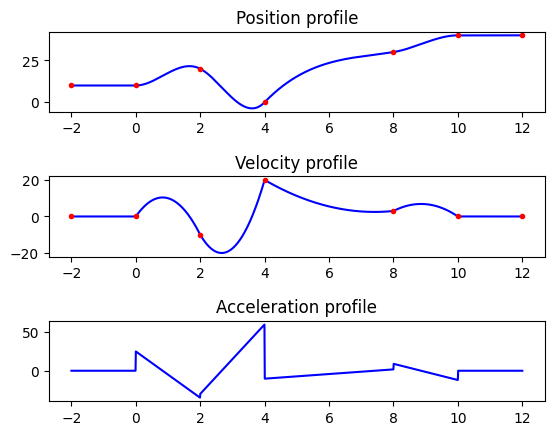

In [87]:
plt.subplots_adjust(hspace = 0.8)
plt.subplot(3, 1, 1)
plt.title('Position profile')
plt.plot(time, position, 'b-')
for i in range(n_points):
    plt.plot(t[i], q[i], 'r.')

plt.subplot(3, 1, 2)
plt.title('Velocity profile')
plt.plot(time, velocity, 'b-')
for i in range(n_points):
    plt.plot(t[i], v[i], 'r.')

plt.subplot(3, 1, 3)
plt.title('Acceleration profile')
    
plt.plot(time, acceleration, 'b-')

plt.show()

The following code solves this finals question using the quintic polynomial method.

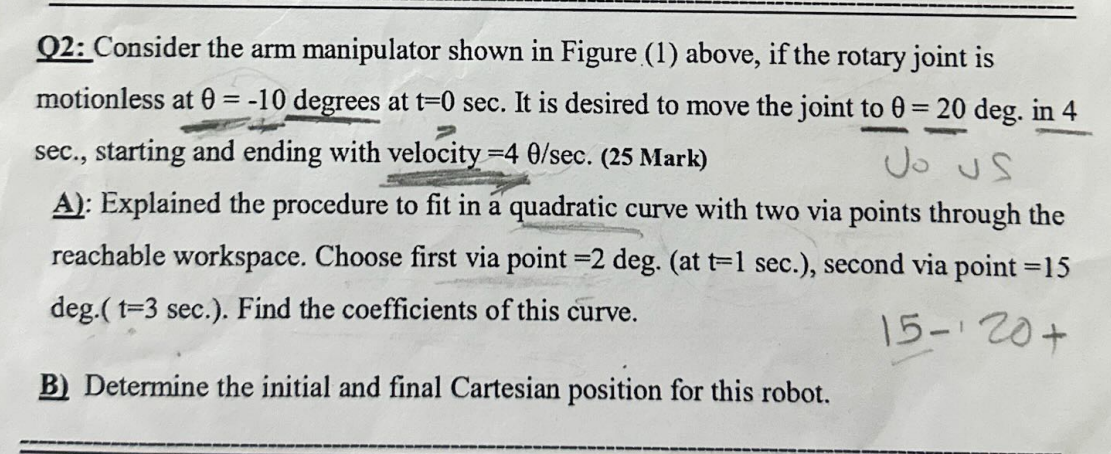

The question specifically asks to solve it using a quadratic polynomial, but we will solve it using a quintic one.


In [2]:
import numpy as np

qi = -10
vi = 4
qf = 20
vf = 4
q1 = 2
q2 = 15
ti = 0
tf = 4
t1 = 1
t2 = 3

a = np.array([
    [1, ti, ti**2, ti**3, ti**4, ti**5],
    [0, 1, 2*ti, 3*ti**2, 4*ti**3, 5*ti**4],
    [1, t1, t1**2, t1**3, t1**4, t1**5],
    [1, t2, t2**2, t2**3, t2**4, t2**5],
    [1, tf, tf**2, tf**3, tf**4, tf**5],
    [0, 1, 2*tf, 3*tf**2, 4*tf**3, 5*tf**4]
])

b = np.array([qi, vi, q1, q2, qf, vf])

a = np.linalg.inv(a) @ b

In [7]:
q = lambda t: a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
v = lambda t: a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4

In [9]:
from matplotlib import pyplot as plt
time = np.linspace(0, 4, 100*4)
path_position = q(time)
path_velocity = v(time)

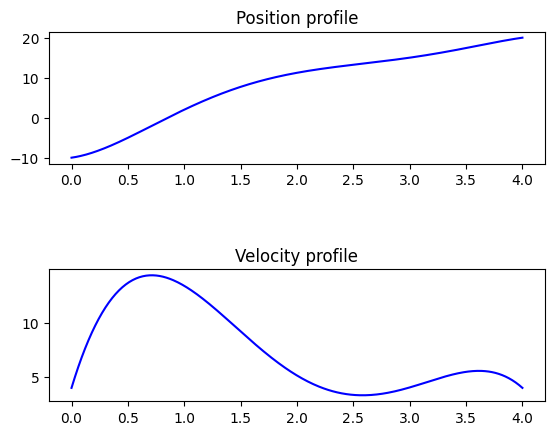

In [12]:
plt.subplots_adjust(hspace = 0.8)
plt.subplot(2, 1, 1)
plt.title('Position profile')
plt.plot(time, path_position, 'b-')
plt.subplot(2, 1, 2)
plt.title('Velocity profile')
plt.plot(time, path_velocity, 'b-')
plt.show()